### 练习3.2.1

如果我们将权重初始化为零，会发生什么。算法仍然有效吗？

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# XOR 输入和标签
X = torch.tensor([[0.,0.], [0.,1.], [1.,0.], [1.,1.]])
y = torch.tensor([[0.], [1.], [1.], [0.5]])

# 简单两层 MLP 网络
class SimpleMLP(nn.Module):
    def __init__(self, init_zero=False):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        if init_zero:
            nn.init.constant_(self.fc1.weight, 0)
            nn.init.constant_(self.fc1.bias, 0)
            nn.init.constant_(self.fc2.weight, 0)
            nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [ ]:
def train(model):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    for epoch in range(1000):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    return model(X).detach()


SyntaxError: invalid syntax (1377497070.py, line 5)

In [94]:
# 1. 随机初始化
model_rand = SimpleMLP(init_zero=False)
output_rand = train(model_rand)
print("随机初始化输出：")
print(output_rand)

# 2. 零初始化
model_zero = SimpleMLP(init_zero=True)
output_zero = train(model_zero)
print("零初始化输出：")
print(output_zero)


随机初始化输出：
tensor([[0.0385],
        [0.9830],
        [0.9646],
        [0.5224]])
零初始化输出：
tensor([[0.6250],
        [0.6250],
        [0.6250],
        [0.6250]])


### 练习3.2.2

假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?

In [95]:
x = torch.randn(100, 1)
y = 30 * x + 10

model = nn.Linear(1, 1)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(500):
    y_pred = model(x)

    loss = criterion(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(model.weight)
print(model.bias)

Parameter containing:
tensor([[29.9995]], requires_grad=True)
Parameter containing:
tensor([10.0004], requires_grad=True)


### 练习3.2.4

计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？

2. 一阶导数的计算图保存问题：计算二阶导数，需要将一阶导数的计算图保存起来，使用`create_graph`和`retain_graph`参数

&emsp;&emsp;以下面函数举例：

- 原函数：$ y = x^3$
- 一阶导函数：$y = 3 x^2$
- 二阶导函数：$y = 6 x$

In [96]:
x = torch.randn(2, requires_grad=True)
y = x ** 3

#一阶导数
dy = torch.autograd.grad(y, x, grad_outputs=torch.ones(x.shape),
                         create_graph=True)

dy2 = torch.autograd.grad(dy, x, grad_outputs=torch.ones(x.shape))

In [97]:
dy[0] == 3 * x**2, dy2[0] == 6 * x

(tensor([True, True]), tensor([True, True]))

在使用backward后，计算图会被释放。
这里不使用backward的原因是backward会直接覆盖x.grad这个属性，而不是返回一个值。

### 练习3.2.5

为什么在`squared_loss`函数中需要使用`reshape`函数？

```python
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
```
是因为
```python
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b
```
其中y_hat是列向量，y是一维行向量.

### 练习3.2.6

尝试使用不同的学习率，观察损失函数值下降的快慢。

In [98]:
%matplotlib inline
import random
import torch
import numpy as np
from d2l import torch as d2l

In [99]:
# 生成数据集
def synthetic_data(w, b, num_inputs):
    out_inputs = len(w)
    X = torch.normal(0, 1, (num_inputs, out_inputs))
    print(f'X.shape={X.shape},w.shape={w.shape},b.shape={b.shape}')
    y = torch.matmul(X, w) + b
    print(f'y.shape={y.shape}')
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([[2], [-3.4]])
print(true_w.shape)
true_b = torch.tensor([2])
true_b = true_b.reshape(1, -1)
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([2, 1])
X.shape=torch.Size([1000, 2]),w.shape=torch.Size([2, 1]),b.shape=torch.Size([1, 1])
y.shape=torch.Size([1000, 1])


对于一个线性神经网络，X,w,b的shape一般是

x: 输入特征
Shape：(batch_size, input_dim)
表示每个样本是一个 input_dim 维的向量，共有 batch_size 个样本。

W: 权重矩阵
Shape：(input_dim, output_dim)
将输入从 input_dim 映射到 output_dim。

b: 偏置项
Shape：(output_dim,) 或 (1, output_dim)（可广播）
对输出的每个维度加上一个偏置值。

y: 输出结果
Shape：(batch_size, output_dim)
最终输出的特征维度是 output_dim。

In [100]:
def data_iter(batch_size, features, labels):
    num_inputs = len(features)
    indices = list(range(num_inputs))
    random.shuffle(indices)
    for i in range(0, num_inputs, batch_size):
        batch_indices = indices[i:min(i+batch_size, num_inputs)]
        yield features[batch_indices], labels[batch_indices]

In [101]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(w.shape)

torch.Size([2, 1])


In [102]:
def linear_regression(X, w, b):
    return torch.matmul(X, w) + b

In [103]:
def squared_loss(y_pred, y):
    return (y_pred - y.reshape(y_pred.shape)) ** 2 / 2

In [104]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [105]:
lrs = [0.5, 0.3, 0.1, 0.01]
num_epochs = 10
net = linear_regression
loss = squared_loss

batch_size = 10

all_lrs = []
for lr in lrs:
    train_lrs = []
    for epoch in range(num_epochs):
        for X, y in data_iter(batch_size, features, labels):
            #清零在sgd里面写了
            y_pred = net(X, w, b)
            l = loss(y_pred, y)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        with torch.no_grad():
            y_pred = net(features, w, b)
            train_loss = loss(y_pred, labels)
            train_lrs.append(float(train_loss.mean()))
    all_lrs.append(train_lrs)

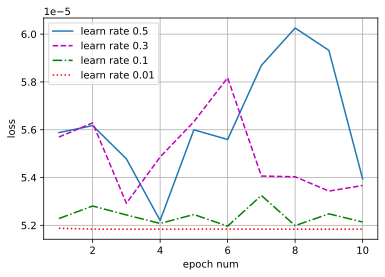

In [106]:
epochs = np.arange(1, num_epochs+1)
d2l.plot(epochs, all_lrs, xlabel='epoch num', ylabel='loss', 
         legend=[f'learn rate {lr}' for lr in lrs],
         figsize=(6, 4))